In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
sys.path.append('..')

from src.logit_graph import simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import powerlaw
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 10})

## Helper Functions

In [47]:
def test_scale_free(G):
    """Test if G is scale-free using the powerlaw package (Clauset et al.).
    
    Uses auto xmin (optimal KS distance) and compares power-law vs exponential.
    R > 0 means power-law is preferred; p < 0.05 means statistically significant.
    """
    result = {
        'power_law_alpha': np.nan,
        'xmin': np.nan,
        'loglikelihood_ratio': np.nan,
        'pl_p_value': np.nan,
        'is_scale_free': False,
    }
    degree_sequence = sorted([d for _, d in G.degree()], reverse=True)
    if len(degree_sequence) < 30 or max(degree_sequence) < 2:
        return result

    fit = powerlaw.Fit(degree_sequence, discrete=True, verbose=False)
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    result['power_law_alpha'] = fit.alpha
    result['xmin'] = fit.xmin
    result['loglikelihood_ratio'] = R
    result['pl_p_value'] = p
    result['is_scale_free'] = R > 0 and p < 0.05
    return result


def analyze_graph(G):
    """Return a dict of key graph properties."""
    n, m = G.number_of_nodes(), G.number_of_edges()
    degrees = np.array([d for _, d in G.degree()])

    props = {
        'n_nodes': n, 'n_edges': m,
        'density': nx.density(G),
        'avg_degree': degrees.mean() if n > 0 else 0,
        'max_degree': int(degrees.max()) if n > 0 else 0,
        'clustering_coefficient': nx.average_clustering(G) if m > 0 else 0.0,
    }
    props.update(test_scale_free(G))
    return props

## Parameter Sweep

In [48]:
def run_parameter_sweep(n=100, n_iterations=5000, patience=1000,
                        n_repeats=3, warm_up=20, er_p=0.001):
    """Sweep over sigma and d values, collecting graph properties."""
    sigma_values = [-5, -2, -1, -0.5, 0, 0.5, 1.0, 2.0]
    d_values = [0, 1, 2]

    results = []
    total = len(sigma_values) * len(d_values) * n_repeats

    for sigma in tqdm(sigma_values, desc='sigma'):
        for d in d_values:
            for repeat in range(n_repeats):
                try:
                    sim = simulation.LogitGraphSimulation(
                        n=n, d=d, sigma=sigma,
                        alpha=1.0, beta=1.0, er_p=er_p,
                        n_iteration=n_iterations,
                        warm_up=warm_up, patience=patience,
                        verbose=False,
                    )
                    sim.simulate()

                    if sim.simulated_graph is not None:
                        props = analyze_graph(sim.simulated_graph)
                        results.append({'sigma': sigma, 'd': d, 'repeat': repeat, **props})
                except Exception as e:
                    print(f'Error (sigma={sigma}, d={d}, repeat={repeat}): {e}')

    return pd.DataFrame(results)

## Run Experiment

In [49]:
results_df = run_parameter_sweep(
    n=50,
    n_iterations=10000,
    warm_up=2000,
    er_p=0.01,
    patience=500,
    n_repeats=3,
)
results_df.head()

sigma:   0%|          | 0/8 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  12%|█▎        | 1/8 [00:16<01:55, 16.54s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  25%|██▌       | 2/8 [00:32<01:38, 16.42s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  38%|███▊      | 3/8 [00:49<01:22, 16.48s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  50%|█████     | 4/8 [01:05<01:05, 16.30s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  62%|██████▎   | 5/8 [01:23<00:51, 17.03s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  75%|███████▌  | 6/8 [01:40<00:34, 17.09s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma:  88%|████████▊ | 7/8 [01:59<00:17, 17.56s/it]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

sigma: 100%|██████████| 8/8 [02:18<00:00, 17.37s/it]


,sigma,d,repeat,n_nodes,n_edges,density,avg_degree,max_degree,clustering_coefficient,power_law_alpha,xmin,loglikelihood_ratio,pl_p_value,is_scale_free
0,-5.0,0,0,50,873,0.712653,34.92,42,0.718882,3.0,28.0,-12.466084,1.143066e-35,False
1,-5.0,0,1,50,783,0.639184,31.32,39,0.645735,3.0,22.0,-43.098979,0.000000e+00,False
2,-5.0,0,2,50,964,0.786939,38.56,44,0.786718,3.0,33.0,-13.892930,6.991586e-44,False
3,-5.0,1,0,50,968,0.790204,38.72,44,0.790327,3.0,33.0,-14.937922,1.867081e-50,False
4,-5.0,1,1,50,979,0.799184,39.16,45,0.797670,3.0,32.0,-19.295857,5.819161e-83,False


In [50]:
display(results_df)

,sigma,d,repeat,n_nodes,n_edges,density,avg_degree,max_degree,clustering_coefficient,power_law_alpha,xmin,loglikelihood_ratio,pl_p_value,is_scale_free
0,-5.0,0,0,50,873,0.712653,34.92,42,0.718882,3.0,28.0,-12.466084,1.143066e-35,False
1,-5.0,0,1,50,783,0.639184,31.32,39,0.645735,3.0,22.0,-43.098979,0.000000e+00,False
2,-5.0,0,2,50,964,0.786939,38.56,44,0.786718,3.0,33.0,-13.892930,6.991586e-44,False
3,-5.0,1,0,50,968,0.790204,38.72,44,0.790327,3.0,33.0,-14.937922,1.867081e-50,False
4,-5.0,1,1,50,979,0.799184,39.16,45,0.797670,3.0,32.0,-19.295857,5.819161e-83,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2.0,1,1,50,990,0.808163,39.60,45,0.808836,3.0,33.0,-16.182461,6.705928e-59,False
68,2.0,1,2,50,1008,0.822857,40.32,44,0.821620,3.0,35.0,-16.616651,5.280099e-62,False
69,2.0,2,0,50,996,0.813061,39.84,46,0.812859,3.0,33.0,-17.681376,5.835438e-70,False
70,2.0,2,1,50,984,0.803265,39.36,45,0.804822,3.0,33.0,-15.599497,7.337048e-55,False


In [51]:
print(f'Experiments: {len(results_df)}')
print(f'Clustering coeff: {results_df["clustering_coefficient"].mean():.4f} \u00b1 {results_df["clustering_coefficient"].std():.4f}')
print(f'Scale-free proportion: {results_df["is_scale_free"].mean():.2%}')
print(f'Avg degree: {results_df["avg_degree"].mean():.2f} \u00b1 {results_df["avg_degree"].std():.2f}')

Experiments: 72
Clustering coeff: 0.8024 ± 0.0242
Scale-free proportion: 0.00%
Avg degree: 39.31 ± 1.23


## Analysis

In [52]:
agg = results_df.groupby(['sigma', 'd']).agg({
    'clustering_coefficient': ['mean', 'std'],
    'power_law_alpha': ['mean', 'std'],
    'loglikelihood_ratio': ['mean', 'std'],
    'pl_p_value': ['mean'],
    'is_scale_free': 'mean',
    'avg_degree': 'mean',
    'density': 'mean',
    'n_edges': 'mean',
}).reset_index()
agg.columns = ['_'.join(c).strip('_') for c in agg.columns]
agg.head(12)

,sigma,d,clustering_coefficient_mean,clustering_coefficient_std,power_law_alpha_mean,power_law_alpha_std,loglikelihood_ratio_mean,loglikelihood_ratio_std,pl_p_value_mean,is_scale_free_mean,avg_degree_mean,density_mean,n_edges_mean
0,-5.0,0,0.717111,0.070508,3.0,0.0,-23.152664,17.288741,3.810220e-36,0.0,34.933333,0.712925,873.333333
1,-5.0,1,0.797309,0.006808,3.0,0.0,-16.516682,2.414259,6.243451e-51,0.0,39.093333,0.797823,977.333333
2,-5.0,2,0.790425,0.005001,3.0,0.0,-16.734587,2.238076,3.977663e-46,0.0,38.746667,0.790748,968.666667
3,-2.0,0,0.794585,0.007921,3.0,0.0,-12.094782,7.374079,9.278089e-05,0.0,38.866667,0.793197,971.666667
4,-2.0,1,0.802607,0.004985,3.0,0.0,-26.742825,8.562001,1.453903e-100,0.0,39.346667,0.802993,983.666667
5,-2.0,2,0.806167,0.009011,3.0,0.0,-17.211142,3.244085,8.366908e-43,0.0,39.453333,0.805170,986.333333
6,-1.0,0,0.804651,0.004171,3.0,0.0,-17.247192,2.436859,1.110676e-51,0.0,39.400000,0.804082,985.000000
7,-1.0,1,0.803754,0.006423,3.0,0.0,-12.958830,5.206673,6.299444e-13,0.0,39.400000,0.804082,985.000000
8,-1.0,2,0.817963,0.018222,3.0,0.0,-13.463012,3.792249,3.538590e-22,0.0,40.013333,0.816599,1000.333333
9,-0.5,0,0.797829,0.004005,3.0,0.0,-17.731810,3.977624,2.127278e-51,0.0,39.160000,0.799184,979.000000


### Clustering Coefficient vs Sigma

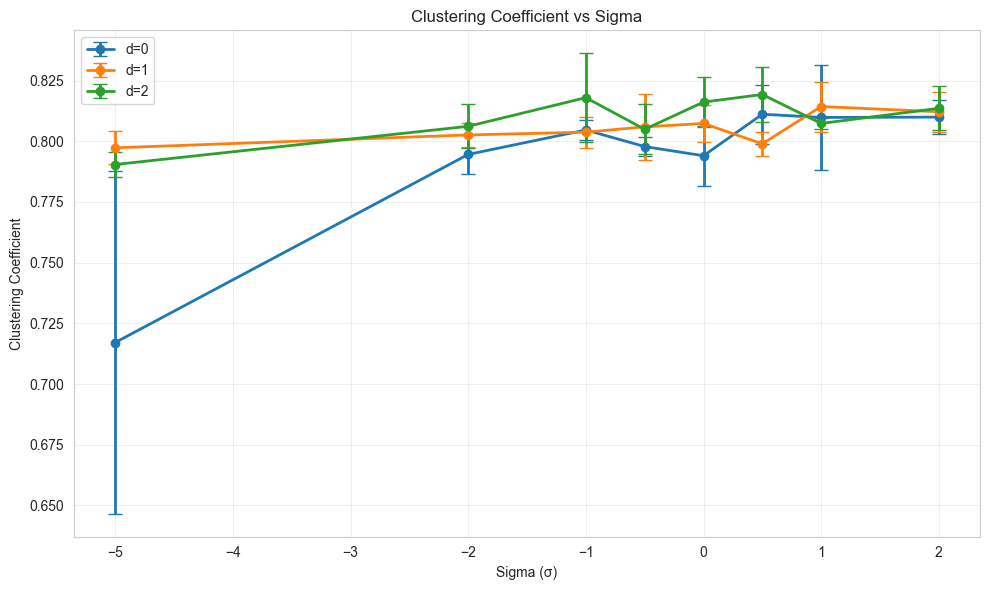

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.errorbar(sub['sigma'], sub['clustering_coefficient_mean'],
                yerr=sub['clustering_coefficient_std'],
                marker='o', label=f'd={d}', capsize=5, linewidth=2)
ax.set(xlabel='Sigma (\u03c3)', ylabel='Clustering Coefficient',
       title='Clustering Coefficient vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Scale-Free Property vs Sigma

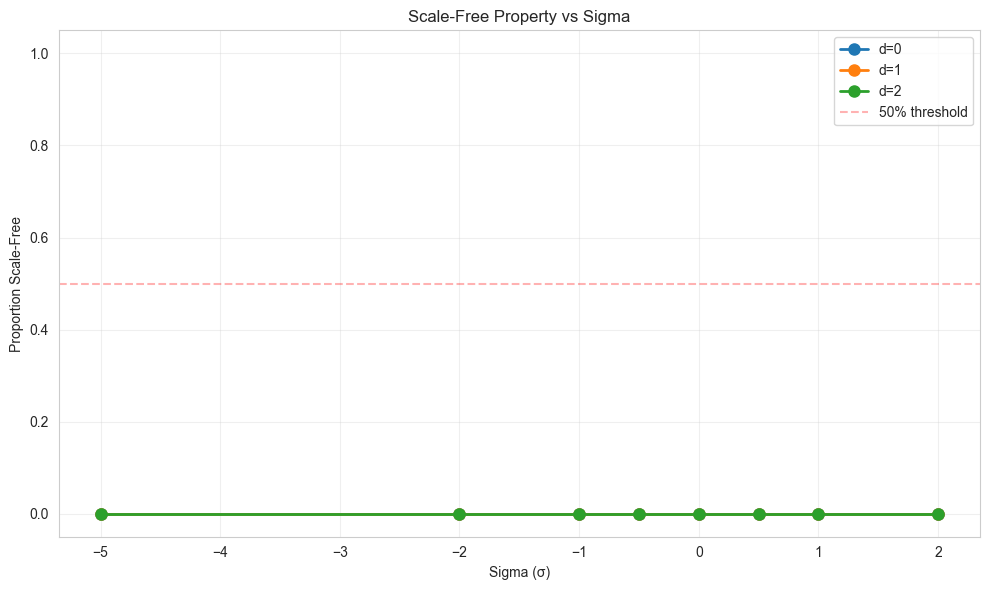

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.plot(sub['sigma'], sub['is_scale_free_mean'],
            marker='o', label=f'd={d}', linewidth=2, markersize=8)
ax.axhline(0.5, color='red', ls='--', alpha=0.3, label='50% threshold')
ax.set(xlabel='Sigma (\u03c3)', ylabel='Proportion Scale-Free', ylim=(-0.05, 1.05),
       title='Scale-Free Property vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Power-Law Exponent vs Sigma

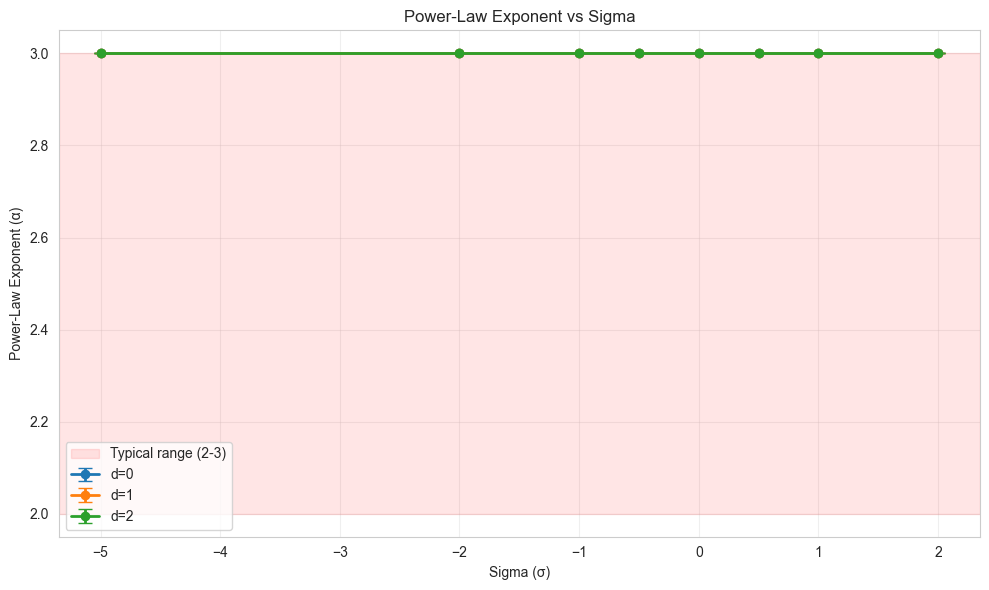

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.errorbar(sub['sigma'], sub['power_law_alpha_mean'],
                yerr=sub['power_law_alpha_std'],
                marker='o', label=f'd={d}', capsize=5, linewidth=2)
ax.axhspan(2.0, 3.0, alpha=0.1, color='red', label='Typical range (2-3)')
ax.set(xlabel='Sigma (\u03c3)', ylabel='Power-Law Exponent (\u03b1)',
       title='Power-Law Exponent vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Heatmaps: Scale-Free & Clustering

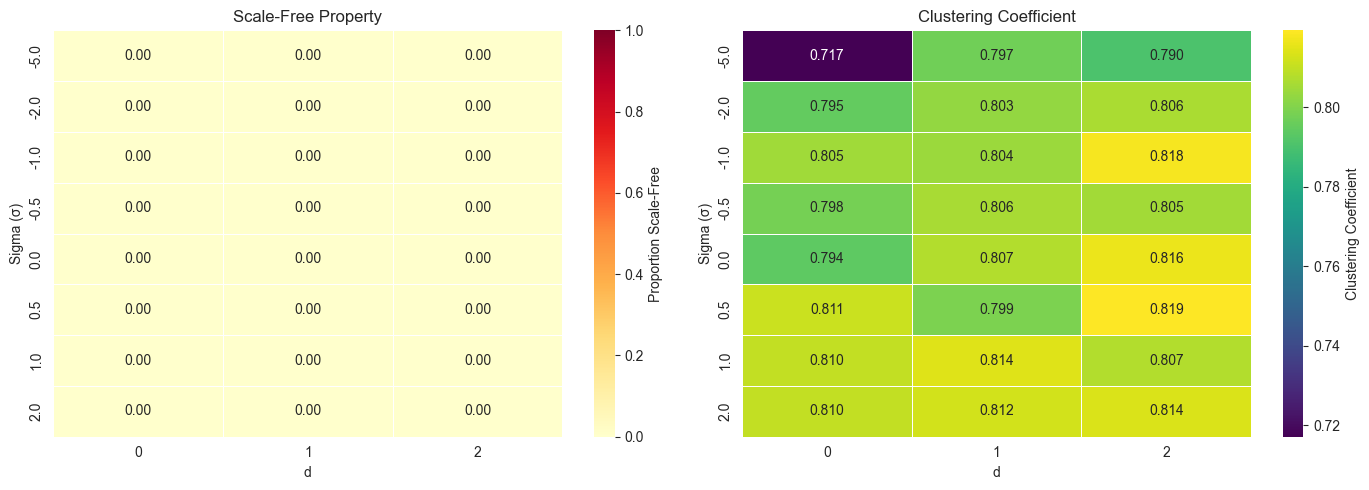

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pivot_sf = agg.pivot_table('is_scale_free_mean', index='sigma', columns='d')
pivot_cc = agg.pivot_table('clustering_coefficient_mean', index='sigma', columns='d')

sns.heatmap(pivot_sf, annot=True, fmt='.2f', cmap='YlOrRd',
            vmin=0, vmax=1, linewidths=.5, ax=ax1,
            cbar_kws={'label': 'Proportion Scale-Free'})
ax1.set(title='Scale-Free Property', xlabel='d', ylabel='Sigma (\u03c3)')

sns.heatmap(pivot_cc, annot=True, fmt='.3f', cmap='viridis',
            linewidths=.5, ax=ax2,
            cbar_kws={'label': 'Clustering Coefficient'})
ax2.set(title='Clustering Coefficient', xlabel='d', ylabel='Sigma (\u03c3)')

plt.tight_layout()
plt.show()

### Correlation Matrix

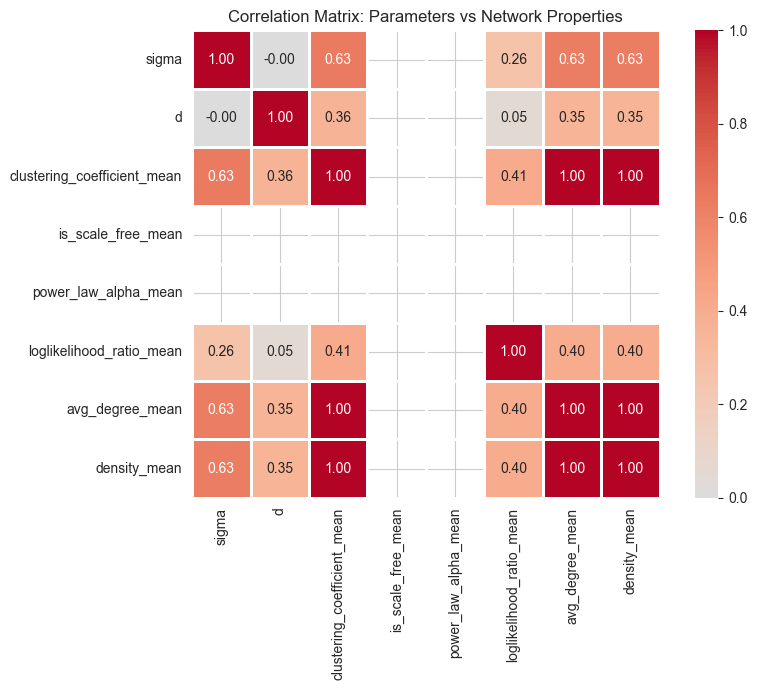

In [57]:
corr_cols = ['sigma', 'd', 'clustering_coefficient_mean', 'is_scale_free_mean',
             'power_law_alpha_mean', 'loglikelihood_ratio_mean', 'avg_degree_mean', 'density_mean']
corr = agg[corr_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix: Parameters vs Network Properties')
plt.tight_layout()
plt.show()

### Statistical Summary

In [58]:
# Configurations with high clustering AND scale-free properties
cc_thresh = agg['clustering_coefficient_mean'].quantile(0.75)
sf_thresh = 0.5

interesting = agg[
    (agg['clustering_coefficient_mean'] > cc_thresh) &
    (agg['is_scale_free_mean'] > sf_thresh)
].sort_values('clustering_coefficient_mean', ascending=False)

show_cols = ['sigma', 'd', 'clustering_coefficient_mean', 'is_scale_free_mean',
             'power_law_alpha_mean', 'avg_degree_mean']

if len(interesting) > 0:
    print(f'Configs with clustering > {cc_thresh:.4f} and scale-free > {sf_thresh}:')
    print(interesting[show_cols].to_string(index=False))
else:
    print('No configs meet both criteria. Relaxing thresholds...')
    relaxed = agg[
        (agg['clustering_coefficient_mean'] > agg['clustering_coefficient_mean'].quantile(0.5)) &
        (agg['is_scale_free_mean'] > 0.3)
    ].sort_values('clustering_coefficient_mean', ascending=False)
    if len(relaxed) > 0:
        print(relaxed[show_cols].to_string(index=False))
    else:
        print('Still no matches.')

No configs meet both criteria. Relaxing thresholds...
Still no matches.


### Degree Distribution Fits

Generate one graph per (sigma, d) combo and plot the CCDF with fitted power-law, exponential, and lognormal.

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

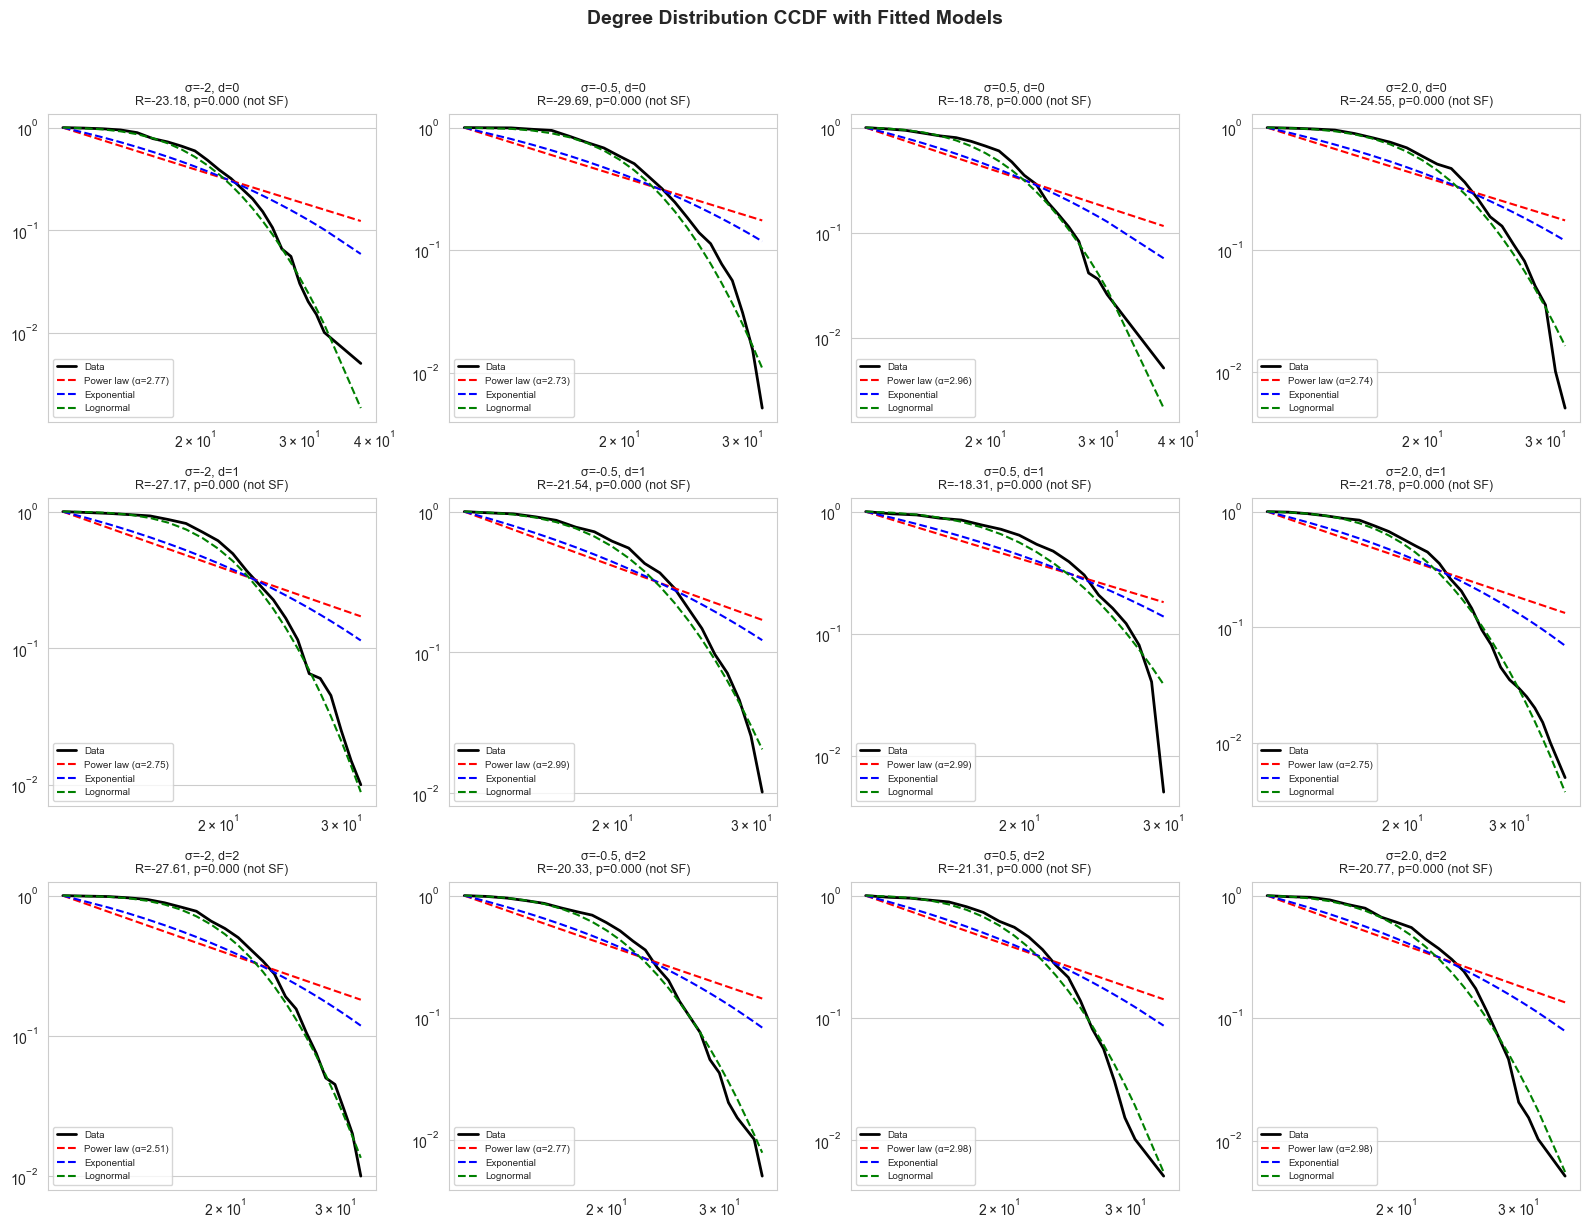

In [60]:
# Pick a subset of sigma values to plot (avoid too many panels)
plot_sigmas = [-2, -0.5, 0.5, 2.0]
plot_d_values = sorted(results_df['d'].unique())

fig, axes = plt.subplots(len(plot_d_values), len(plot_sigmas),
                         figsize=(4 * len(plot_sigmas), 4 * len(plot_d_values)),
                         squeeze=False)

for row, d in enumerate(plot_d_values):
    for col, sigma in enumerate(plot_sigmas):
        ax = axes[row][col]

        # Re-generate one graph for this combo
        sim = simulation.LogitGraphSimulation(
            n=200, d=d, sigma=sigma,
            alpha=1.0, beta=1.0, er_p=0.01,
            n_iteration=10000, warm_up=2000, patience=500,
            verbose=False,
        )
        sim.simulate()
        G = sim.simulated_graph

        if G is None or G.number_of_edges() < 5:
            ax.text(0.5, 0.5, 'Too sparse', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'\u03c3={sigma}, d={d}', fontsize=9)
            continue

        degree_seq = sorted([deg for _, deg in G.degree()], reverse=True)
        if max(degree_seq) < 2:
            ax.text(0.5, 0.5, 'Max degree < 2', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'\u03c3={sigma}, d={d}', fontsize=9)
            continue

        fit = powerlaw.Fit(degree_seq, discrete=True, verbose=False)
        R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

        # Plot empirical CCDF
        fit.plot_ccdf(ax=ax, color='black', linewidth=2, label='Data')
        # Plot fitted distributions
        fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label=f'Power law (\u03b1={fit.alpha:.2f})')
        fit.exponential.plot_ccdf(ax=ax, color='b', linestyle='--', label='Exponential')
        fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--', label='Lognormal')

        sf_label = 'SF' if R > 0 and p < 0.05 else 'not SF'
        ax.set_title(f'\u03c3={sigma}, d={d}\nR={R:.2f}, p={p:.3f} ({sf_label})', fontsize=9)
        ax.legend(fontsize=7, loc='lower left')

fig.suptitle('Degree Distribution CCDF with Fitted Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

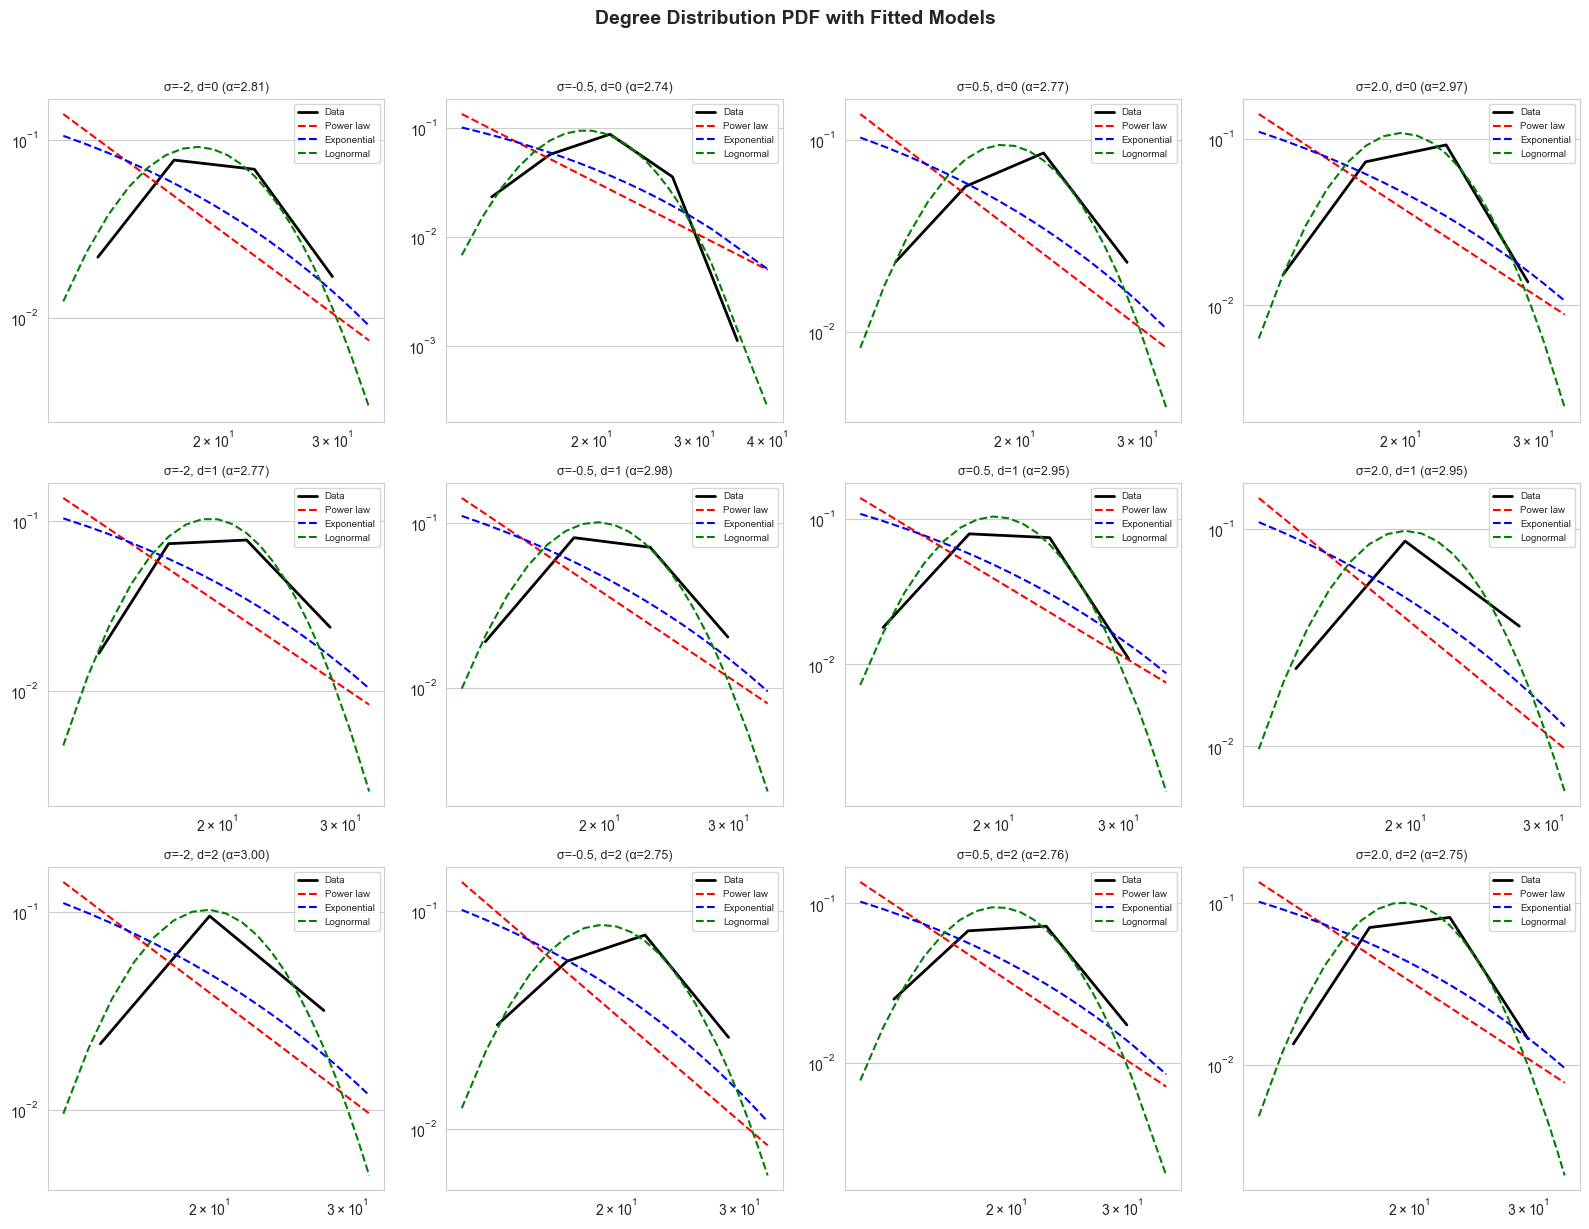

In [61]:
# Also plot the PDF for the same configurations
fig, axes = plt.subplots(len(plot_d_values), len(plot_sigmas),
                         figsize=(4 * len(plot_sigmas), 4 * len(plot_d_values)),
                         squeeze=False)

for row, d in enumerate(plot_d_values):
    for col, sigma in enumerate(plot_sigmas):
        ax = axes[row][col]

        sim = simulation.LogitGraphSimulation(
            n=200, d=d, sigma=sigma,
            alpha=1.0, beta=1.0, er_p=0.01,
            n_iteration=10000, warm_up=2000, patience=500,
            verbose=False,
        )
        sim.simulate()
        G = sim.simulated_graph

        if G is None or G.number_of_edges() < 5 or max([deg for _, deg in G.degree()]) < 2:
            ax.text(0.5, 0.5, 'Too sparse', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'\u03c3={sigma}, d={d}', fontsize=9)
            continue

        degree_seq = sorted([deg for _, deg in G.degree()], reverse=True)
        fit = powerlaw.Fit(degree_seq, discrete=True, verbose=False)

        # Plot empirical PDF
        fit.plot_pdf(ax=ax, color='black', linewidth=2, label='Data')
        fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', label='Power law')
        fit.exponential.plot_pdf(ax=ax, color='b', linestyle='--', label='Exponential')
        fit.lognormal.plot_pdf(ax=ax, color='g', linestyle='--', label='Lognormal')

        ax.set_title(f'\u03c3={sigma}, d={d} (\u03b1={fit.alpha:.2f})', fontsize=9)
        ax.legend(fontsize=7, loc='upper right')

fig.suptitle('Degree Distribution PDF with Fitted Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()